Multi-level Perturbed Unit Gradient Descent, MPUGD

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data  import Subset, DataLoader

import torchvision
import torchvision.transforms as transforms
from types import SimpleNamespace 
import matplotlib.pyplot  as plt
import numpy as np 

from optimizers import *
from upanets import UPANets
from torchsummary import summary
import time, copy,timm
import json
import random 
import os
from train import *

e:\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
args = SimpleNamespace(
    datasets='cifar_100',
    batch_size = 500,
    seed = 42,
    lr=0.1, 
    momentum=0.9,
    wd = 0.0005,
    blocks = 1,
    filters = 16,
    epochs = 400,
    start_epochs = 8
    )

In [3]:
def set_all_seeds(seed=42):
    # Python原生随机 
    random.seed(seed) 
    # NumPy随机 
    np.random.seed(seed) 
    # PyTorch随机 
    torch.manual_seed(seed) 
    # CUDA随机（GPU相关）
    torch.cuda.manual_seed_all(seed) 
    # CUDNN确定性模式 
    torch.backends.cudnn.deterministic  = True 
    torch.backends.cudnn.benchmark  = False 
 
set_all_seeds(args.seed)  

In [4]:
print(device)

cuda


In [5]:
img_size = 32 # default image size for Cifar-10
im_dimention = 32
cifar_10_mean = [0.4914, 0.4822, 0.4465] 
cifar_10_std = [0.2023, 0.1994, 0.2010]
cifar_100_mean = [0.5071, 0.4867, 0.4408]
cifar_100_std = [0.2673, 0.2564, 0.2762]

if args.datasets == 'cifar_10':
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.RandomRotation(15,),
            transforms.RandomCrop(im_dimention),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
            # transforms.Lambda(lambda x: x.to(torch.float16))    # 最终输出FP16
        ]),
        # 'valid': transforms.Compose([
        #     transforms.Resize((im_dimention,im_dimention)),
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        # ]),
        'test': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        ]),
    }
 
    full_trainset = torchvision.datasets.CIFAR10(
        root='./data/cifar_10', train=True, download=True, transform=data_transforms['train'])
    testset = torchvision.datasets.CIFAR10(
        root='./data/cifar_10', train=False, download=True, transform=data_transforms['test'])
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=args.batch_size, shuffle=False, num_workers=0)
    Num_class = 10

if args.datasets == 'cifar_100':
    data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(im_dimention),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    # 'valid': transforms.Compose([
    #     transforms.Resize((im_dimention,im_dimention)),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    # ]),
    'test': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    }
    full_trainset = torchvision.datasets.CIFAR100(
        root='./data/cifar_100', train=True, download=True, transform=data_transforms['train'])
    testset = torchvision.datasets.CIFAR100(
        root='./data/cifar_100', train=False, download=True, transform=data_transforms['test'])
    testloader = DataLoader(
        testset, batch_size=args.batch_size, shuffle=False,sampler=torch.utils.data.SequentialSampler(testset),  num_workers=0)
    Num_class = 100

# # 获取所有样本的标签 
# labels = [full_trainset[i][1] for i in range(len(full_trainset))]

# # 分层划分（stratify参数确保比例）
# train_idx, val_idx = train_test_split(
#     range(len(full_trainset)),
#     test_size=0.2,
#     shuffle=True,
#     stratify=labels,
#     random_state=args.seed  
# )

# train_data = np.stack([full_trainset.data[i]  for i in train_idx]) 
# train_targets = [full_trainset.targets[i] for i in train_idx] 
# val_data = np.stack([full_trainset.data[i]  for i in val_idx]) 
# val_targets = [full_trainset.targets[i] for i in val_idx] 

# valset = full_trainset
# valset.data = val_data
# valset.targets = val_targets
# valset.transform = data_transforms['valid']

# trainset = copy.deepcopy(valset)
# trainset.data = train_data
# trainset.targets = train_targets
# trainset.transform = data_transforms['train']

# trainloader = {
#     'train':DataLoader(
#     trainset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(trainset), num_workers=0),
#     'valid':DataLoader(
#     valset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(valset), num_workers=0)}

# dataset_sizes = {
#     'train': len(trainset),
#     'valid': len(valset),            
                #  }

trainloader = {
    'train':DataLoader(
    full_trainset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(full_trainset), num_workers=0),
    'valid':testloader
}

dataset_sizes = {
    'train': len(full_trainset),
    'valid': len(testset),      
}
print(dataset_sizes)


{'train': 50000, 'valid': 10000}


In [6]:
print(timm.list_models('*vit_tiny_patch16_224*')) 

['vit_tiny_patch16_224']


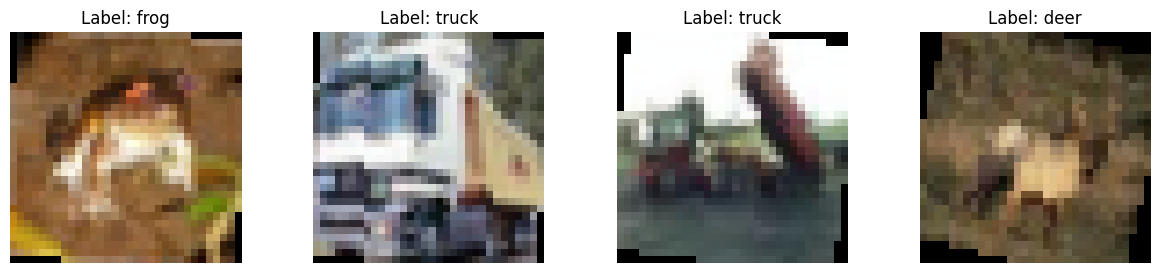

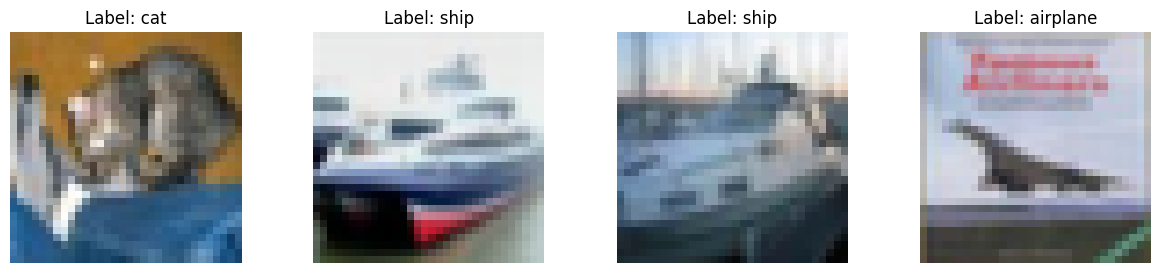

In [7]:
# from torchvision.transforms.functional  import to_pil_image 
# 反归一化转换（需与transform中的参数对应）
inv_normalize = transforms.Normalize(
    mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
    std=[1/0.2023, 1/0.1994, 1/0.2010]
)
 
def show_images(loader, num_images=4):
    # 获取一个batch的数据 
    # images, labels = next(iter(loader))
    for batch_idx, (images, labels) in enumerate(loader):
        if batch_idx == 0:  # 只取第一个batch 
            break 

    # 创建子图 
    fig, axes = plt.subplots(1,  num_images, figsize=(15, 3))
    
    for i in range(num_images):
        # 反归一化+通道顺序调整 
        img = inv_normalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img,  0, 1)  # 处理浮点误差 
        
        # 显示图像及标签 
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {full_trainset.classes[labels[i]]}") 
        axes[i].axis('off')
    
    plt.show() 
 
show_images(trainloader['train'])
show_images(testloader)

In [8]:
model_path = "./model/" + args.datasets + "/benckmark.pth"
if os.path.exists(model_path):
    net_benckmark_data = torch.load(model_path,  map_location='cpu')
    benckmark_state_dict = net_benckmark_data['model_state_dict'] 
else:
    net_benchmark = UPANets(args.filters, Num_class, args.blocks, img_size)
    torch.save({
        'model_state_dict': net_benchmark.state_dict()
    }, model_path)
    benckmark_state_dict = net_benchmark.state_dict()

def tensor_to_serializable(obj):
    if isinstance(obj, (np.float32,  np.float64)):   # 处理NumPy浮点数
        return float(obj)
    elif isinstance(obj, np.integer):               # 处理NumPy整数 
        return int(obj)
    elif isinstance(obj, torch.Tensor):            # 处理PyTorch Tensor 
        return obj.item()  if obj.numel()  == 1 else obj.tolist() 
    elif isinstance(obj, (np.ndarray)):             # 处理NumPy数组 
        return obj.tolist() 
    elif hasattr(obj, '__dict__'):                 # 处理自定义对象（可选）
        return obj.__dict__
    return obj 


In [ ]:
# net_pugdt_delta = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdt_delta.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdt_delta.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdt_delta = torch.nn.DataParallel(net_pugdt_delta)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXT(net_pugdt_delta.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdt_delta, metricst_delta = train_model_timing_delta(net_pugdt_delta, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes, int(args.epochs/10), 0.01, 10) 

# model_path = "./model/"+args.datasets+"/pugdt_delta_" + str(args.epochs) + "xi" + str(args.epochs/10) + "mu0.01_t10.pth"
# torch.save({
#     'model_state_dict': net_pugdt_delta.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdt_delta_" + str(args.epochs) + "xi" + str(args.epochs/10) + "mu0.01_t10.json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricst_delta,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [10]:
# net_pugdt_var = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdt_var.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdt_var.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdt_var = torch.nn.DataParallel(net_pugdt_var)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXT(net_pugdt_var.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdt_var, metricst_var = train_model_timing_var(net_pugdt_var, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes, int(args.epochs/10), 0.015, 10) 

# model_path = "./model/"+args.datasets+"/pugdt_var_" + str(args.epochs) + "init_t" + str(args.epochs/10) + "gamma0.015_k10.pth"
# torch.save({
#     'model_state_dict': net_pugdt_var.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdt_var_" + str(args.epochs) + "init_t" + str(args.epochs/10) + "gamma0.015_k10.json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricst_var,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [11]:
# net = UPANets(args.filters, Num_class, args.blocks, img_size)
# net.load_state_dict(copy.deepcopy(benckmark_state_dict))

# criterion = torch.nn.CrossEntropyLoss()

# net.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True

# optimizer = optim.SGD(net.parameters(),
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net, metrics_org = train_model_org(net, criterion, optimizer, scheduler, args.epochs * 2, trainloader, device, dataset_sizes) 

# # 保存模型架构+参数+优化器状态（完整恢复训练）
# model_path = "./model/"+args.datasets+"/org" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/org_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metrics_org, f, default=tensor_to_serializable, ensure_ascii=False, indent=4)
 
# # 加载 

# # checkpoint = torch.load('full_model_checkpoint.pth',  map_location='cpu')  # 先加载到CPU避免设备冲突 
# # 模型结构需提前定义（需与保存时一致）
# # model = YourModelClass()  
# # model.load_state_dict(checkpoint['model_state_dict']) 
 
# # # 恢复优化器和训练状态 
# # optimizer = torch.optim.Adam(model.parameters())  
# # optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 
# # with open('data.json',  'r', encoding='utf-8') as f:
# #     loaded_dict = json.load(f) 


# # summary(net, (3, img_size, img_size))


In [ ]:
net_pugdr_sin = UPANets(args.filters, Num_class, args.blocks, img_size)
net_pugdr_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugdr_sin.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(net_pugdr_sin)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXR(net_pugdr_sin.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.0, 
                max_beta = 1.0, 
                method = 'sin',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugdr_sin, metricsr_sin = train_model_alpha(net_pugdr_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugdr_sin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugdr_sin.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugdr_sin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [ ]:
net_pugdr_cos = UPANets(args.filters, Num_class, args.blocks, img_size)
net_pugdr_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugdr_cos.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(net_pugdr_cos)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXR(net_pugdr_cos.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.0, 
                max_beta = 1.0, 
                method = 'cos',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugdr_cos, metricsr_sin = train_model_alpha(net_pugdr_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugdr_cos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugdr_cos.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugdr_cos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
42.556891679763794
Epoch 1/399
42.627238035202026
Epoch 2/399
42.505244731903076
Epoch 3/399
42.47157073020935
Epoch 4/399
42.37897706031799
Epoch 5/399
42.38459134101868
Epoch 6/399
42.39468717575073
Epoch 7/399
42.596007347106934
Epoch 8/399
42.361759424209595
Epoch 9/399
42.407169580459595
Epoch 10/399
42.426682233810425
Epoch 11/399
42.435829877853394
Epoch 12/399
42.43270301818848
Epoch 13/399
42.522181272506714
Epoch 14/399
42.36040425300598
Epoch 15/399
42.44114017486572
Epoch 16/399
42.465068340301514
Epoch 17/399
42.48325300216675
Epoch 18/399
42.37087631225586
Epoch 19/399
42.62265920639038
Epoch 20/399
42.47971439361572
Epoch 21/399
42.5091872215271
Epoch 22/399
42.46988081932068
Epoch 23/399
42.450042963027954
Epoch 24/399
42.62652802467346
Epoch 25/399
42.468355894088745
Epoch 26/399
42.47894763946533
Epoch 27/399
42.423863887786865
Epoch 28/399
42.48484754562378
Epoch 29/399
42.49511909484863
Epoch 30/399
42.585739612579346
Epoch 31/399
42.42453122138977
Epoch

In [ ]:
net_pugds_cos = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugds_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugds_cos.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    net_pugds_cos = torch.nn.DataParallel(net_pugds_cos)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXS(net_pugds_cos.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.0, 
                max_beta = 1.0,
                method = 'cos',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugds_cos, metricss_cos = train_model_alpha(net_pugds_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugds_cos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugds_cos.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugds_cos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricss_cos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
42.89737820625305
Epoch 1/399
42.886202573776245
Epoch 2/399
42.904279708862305
Epoch 3/399
42.978835344314575
Epoch 4/399
43.06062698364258
Epoch 5/399
42.85405349731445
Epoch 6/399
42.904996395111084
Epoch 7/399
42.9443838596344
Epoch 8/399
42.88598656654358
Epoch 9/399
42.888307332992554
Epoch 10/399
43.07091760635376
Epoch 11/399
42.80784606933594
Epoch 12/399
42.84196496009827
Epoch 13/399
42.874165296554565
Epoch 14/399
42.86141753196716
Epoch 15/399
42.92772674560547
Epoch 16/399
42.83970880508423
Epoch 17/399
42.79581022262573
Epoch 18/399
42.82307147979736
Epoch 19/399
42.74210453033447
Epoch 20/399
42.75408864021301
Epoch 21/399
42.87228584289551
Epoch 22/399
42.70814323425293
Epoch 23/399
42.746623516082764
Epoch 24/399
42.760257720947266
Epoch 25/399
42.78992795944214
Epoch 26/399
42.7598831653595
Epoch 27/399
43.03541612625122
Epoch 28/399
42.80025506019592
Epoch 29/399
42.78372764587402
Epoch 30/399
42.82058000564575
Epoch 31/399
42.8318145275116
Epoch 32/399


In [ ]:
net_pugds_sin = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugds_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugds_sin.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    net_pugds_sin = torch.nn.DataParallel(net_pugds_sin)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXS(net_pugds_sin.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.0, 
                max_beta = 1.0,
                method = 'sin',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

net_pugds_sin, metricss_sin = train_model_alpha(net_pugds_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugds_sin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugds_sin.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugds_sin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricss_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
42.90807867050171
Epoch 1/399
42.92734146118164
Epoch 2/399
42.7276451587677
Epoch 3/399
42.89685392379761
Epoch 4/399
42.78191900253296
Epoch 5/399
42.8134241104126
Epoch 6/399
42.7429358959198
Epoch 7/399
42.681318283081055
Epoch 8/399
42.57221460342407
Epoch 9/399
42.864458084106445
Epoch 10/399
42.74184060096741
Epoch 11/399
42.73948335647583
Epoch 12/399
42.66003346443176
Epoch 13/399
42.72301435470581
Epoch 14/399
42.69406223297119
Epoch 15/399
42.56594753265381
Epoch 16/399
42.84002184867859
Epoch 17/399
42.79481792449951
Epoch 18/399
42.821922063827515
Epoch 19/399
42.721232175827026
Epoch 20/399
42.97334551811218
Epoch 21/399
42.67070531845093
Epoch 22/399
42.681933641433716
Epoch 23/399
42.72222876548767
Epoch 24/399
42.770763635635376
Epoch 25/399
42.779855251312256
Epoch 26/399
42.89642071723938
Epoch 27/399
42.88448095321655
Epoch 28/399
42.87728524208069
Epoch 29/399
42.91321873664856
Epoch 30/399
42.97309756278992
Epoch 31/399
42.97639322280884
Epoch 32/399
4

In [ ]:
net_pugd = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugd.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugd.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(net_pugd)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDX(net_pugd.parameters(),
                base_optimizer,
                lr=args.lr,
                momentum=args.momentum,
                weight_decay=args.wd,
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugd, metrics0 = train_model(net_pugd, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugd" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugd.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugd_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [ ]:
net_pugdr_cos = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugdr_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugdr_cos.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(net_pugdr_cos)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXR(net_pugdr_cos.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.01, 
                max_beta = 2, 
                method = 'icos',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                )
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

net_pugdr_cos, metricsr_cos = train_model_alpha(net_pugdr_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugdr_icos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugdr_cos.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugdr_icos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricsr_cos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [ ]:
net_pugdr_sin = UPANets(args.filters, Num_class, args.blocks, img_size)
net_pugdr_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugdr_sin.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(net_pugdr_sin)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXR(net_pugdr_sin.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.01, 
                max_beta = 2, 
                method = 'isin',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugdr_sin, metricsr_sin = train_model_alpha(net_pugdr_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugdr_isin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugdr_sin.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugdr_isin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [ ]:
net_pugds_icos = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugds_icos.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugds_icos.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    net_pugds_icos = torch.nn.DataParallel(net_pugds_icos)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXS(net_pugds_icos.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0, 
                max_beta = 1, 
                method = 'icos',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

net_pugds_icos, metricss_icos = train_model_alpha(net_pugds_icos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugds_icos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugds_icos.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugds_icos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricss_icos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [ ]:
net_pugds_isin = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugds_isin.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugds_isin.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    net_pugds_isin = torch.nn.DataParallel(net_pugds_isin)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXS(net_pugds_isin.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0, 
                max_beta = 1, 
                method = 'isin',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugds_isin, metricss_isin = train_model_alpha(net_pugds_isin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugds_isin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugds_isin.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugds_isin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricss_isin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [ ]:
# net_pugdrs = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdrs.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdrs.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdrs = torch.nn.DataParallel(net_pugdrs)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXRS(net_pugdrs.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta_r = 0.1, 
#                 max_beta_r = 2, 
#                 method_r = 'isin',
#                 min_beta_s = 0.5, 
#                 max_beta_s = 1.0,
#                 method_s = 'cos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdrs, metricsrs = train_model_alpha(net_pugdrs, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdrs_" + str(optimizer.method_r) + str(optimizer.max_beta_r) + "_" + str(optimizer.min_beta_r) + "_" + str(optimizer.method_s) + str(optimizer.max_beta_s) + "_" + str(optimizer.min_beta_s) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdrs.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdrs_" + str(optimizer.method_r) + str(optimizer.max_beta_r) + "_" + str(optimizer.min_beta_r) + "_" + str(optimizer.method_s) + str(optimizer.max_beta_s) + "_" + str(optimizer.min_beta_s) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsrs,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
42.97974920272827
Epoch 1/399
42.97359228134155
Epoch 2/399
42.954132080078125
Epoch 3/399
43.17107796669006
Epoch 4/399
42.9467875957489
Epoch 5/399
42.98615789413452
Epoch 6/399
42.99045515060425
Epoch 7/399
42.897700786590576
Epoch 8/399
43.02285814285278
Epoch 9/399
42.96253538131714
Epoch 10/399
42.98242378234863
Epoch 11/399
42.93050408363342
Epoch 12/399
42.9293487071991
Epoch 13/399
42.95702385902405
Epoch 14/399
43.186853885650635
Epoch 15/399
42.93762922286987
Epoch 16/399
42.85246157646179
Epoch 17/399
42.93027067184448
Epoch 18/399
42.873645544052124
Epoch 19/399
42.86436486244202
Epoch 20/399
43.106831550598145
Epoch 21/399
42.88894534111023
Epoch 22/399
42.96372056007385
Epoch 23/399
42.87868070602417
Epoch 24/399
42.88579320907593
Epoch 25/399
42.89908194541931
Epoch 26/399
43.06455898284912
Epoch 27/399
42.85402870178223
Epoch 28/399
42.866642475128174
Epoch 29/399
42.84166407585144
Epoch 30/399
42.71384620666504
Epoch 31/399
42.94117617607117
Epoch 32/399
4

In [ ]:
# net_pugdrs = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdrs.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdrs.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdrs = torch.nn.DataParallel(net_pugdrs)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXRS(net_pugdrs.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta_r = 0.1, 
#                 max_beta_r = 2, 
#                 method_r = 'icos',
#                 min_beta_s = 0.5, 
#                 max_beta_s = 1.0,
#                 method_s = 'cos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdrs, metricsrs = train_model_alpha(net_pugdrs, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdrs_" + str(optimizer.method_r) + str(optimizer.max_beta_r) + "_" + str(optimizer.min_beta_r) + "_" + str(optimizer.method_s) + str(optimizer.max_beta_s) + "_" + str(optimizer.min_beta_s) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdrs.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdrs_" + str(optimizer.method_r) + str(optimizer.max_beta_r) + "_" + str(optimizer.min_beta_r) + "_" + str(optimizer.method_s) + str(optimizer.max_beta_s) + "_" + str(optimizer.min_beta_s) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsrs,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
42.829018354415894
Epoch 1/399
42.68569302558899
Epoch 2/399
42.65649700164795
Epoch 3/399
42.710912227630615
Epoch 4/399
42.70560550689697
Epoch 5/399
42.67535066604614
Epoch 6/399
42.84627318382263
Epoch 7/399
42.85310745239258
Epoch 8/399
42.773568868637085
Epoch 9/399
42.86480355262756
Epoch 10/399
42.77910232543945
Epoch 11/399
42.911890268325806
Epoch 12/399
42.96463441848755
Epoch 13/399
42.834092140197754
Epoch 14/399
42.81123685836792
Epoch 15/399
42.78596758842468
Epoch 16/399
42.797192096710205
Epoch 17/399
42.7611186504364
Epoch 18/399
42.77322793006897
Epoch 19/399
42.61529588699341
Epoch 20/399
42.567989110946655
Epoch 21/399
42.5709445476532
Epoch 22/399
42.52836012840271
Epoch 23/399
42.65792202949524
Epoch 24/399
42.5321831703186
Epoch 25/399
42.486177921295166
Epoch 26/399
42.51192545890808
Epoch 27/399
42.59483218193054
Epoch 28/399
42.5522997379303
Epoch 29/399
42.70789957046509
Epoch 30/399
42.62356615066528
Epoch 31/399
42.62167549133301
Epoch 32/399
4

In [23]:
# VGG-16 ResNet-18 DenseNet-121* growth rate in 16 UPANet-16 Overall Average

In [24]:
# ## finetune

# from transformers import ViTForImageClassification, DeiTForImageClassification 
 
# # 加载预训练模型 
# vit_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=10, ignore_mismatched_sizes=True, device_map="auto", resume_download=True) 
# deit_model = DeiTForImageClassification.from_pretrained("facebook/deit-base-patch16-224", num_labels=10, ignore_mismatched_sizes=True, device_map="auto", resume_download=True) 



In [25]:
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
#     optimizer,  # 绑定的优化器对象 
#     mode='max',  # 监测指标模式 
#     factor=0.5,  # 学习率衰减系数 
#     patience=3   # 等待周期数 
# )
# for name, param in vit_model.named_parameters(): 
#     if 'encoder.layer.0'  in name:  # 冻结前N层 
#         param.requires_grad  = False 
# # 修改分类头以适应CIFAR-10的10类 
# vit_model.classifier  = torch.nn.Linear(vit_model.config.hidden_size,  10)
# deit_model.classifier  = torch.nn.Linear(deit_model.config.hidden_size,  10)

In [26]:
# print(new_head.__dict__)
# print(vars(new_head))
# import optimizers
# import importlib 
# importlib.reload(optimizers)   
# from optimizers import *

In [27]:
# model_ft2 = timm.create_model('mobilenetv3_small_100', pretrained=True, num_classes=Num_class)
# original_head = model_ft2.classifier   # MobileNetV3的分类头名为classifier 
# new_head = nn.Linear(original_head.in_features,  Num_class)
# model_ft2 = model_ft2.to(device)
# criterion = torch.nn.CrossEntropyLoss()


# base_optimizer2 = optim.SGD
# optimizer2 = PUGD2(model_ft2.parameters(),
#                  base_optimizer2,
#                  lr=args.lr,
#                  momentum=args.momentum,
#                  weight_decay=args.wd,
#                  )


# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1)

# model_ft2 = train_model2(model_ft2, criterion, optimizer2, exp_lr_scheduler, num_epochs=20) 